In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [41]:
df = pd.read_csv(f'../data/processed/train_processed_dummy.csv')
df.head()

,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],CO2_working_capacity [mL/g],topology_acs,topology_bcu,topology_etb,topology_fof,topology_nbo,topology_pcu,topology_pts,...,organic_linker2_57,organic_linker2_58,organic_linker2_59,metal_linker_1,metal_linker_2,metal_linker_3,metal_linker_4,metal_linker_9,metal_linker_10,metal_linker_12
0,22.864166,6.786041,105.284502,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,33.616780,7.147286,101.224774,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,19.263726,6.347967,118.987011,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,25.701377,6.190085,187.626004,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,30.001838,6.478063,79.210001,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [42]:
samples = df.drop(columns='CO2_working_capacity [mL/g]')
labels = df['CO2_working_capacity [mL/g]']

In [43]:
X_train, X_test, y_train, y_test, = train_test_split(samples, labels, test_size=0.3, random_state=122)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=141)

In [44]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(46566, 174) (46566,)
(9979, 174) (9979,)
(9979, 174) (9979,)


## XGBoost

In [49]:
from xgboost import XGBRegressor

In [50]:
xgboost_model = XGBRegressor(
    n_estimators=10000,
    objective='reg:squarederror',
    n_jobs=-1, learning_rate=1e-3
)

In [51]:
xgboost_model.fit(
    X_train.values, y_train.values,
    eval_set = [(X_train.values, y_train.values), (X_test.values, y_test.values)],
    eval_metric = 'mae',
    early_stopping_rounds=10,
    verbose = True
)

[0]	validation_0-mae:123.50798	validation_1-mae:123.91596
[1]	validation_0-mae:123.38476	validation_1-mae:123.79274
[2]	validation_0-mae:123.26166	validation_1-mae:123.66958
[3]	validation_0-mae:123.13862	validation_1-mae:123.54655
[4]	validation_0-mae:123.01575	validation_1-mae:123.42368
[5]	validation_0-mae:122.89304	validation_1-mae:123.30090
[6]	validation_0-mae:122.77039	validation_1-mae:123.17825
[7]	validation_0-mae:122.64793	validation_1-mae:123.05573
[8]	validation_0-mae:122.52551	validation_1-mae:122.93333
[9]	validation_0-mae:122.40327	validation_1-mae:122.81104
[10]	validation_0-mae:122.28116	validation_1-mae:122.68890
[11]	validation_0-mae:122.15915	validation_1-mae:122.56683
[12]	validation_0-mae:122.03728	validation_1-mae:122.44491
[13]	validation_0-mae:121.91550	validation_1-mae:122.32311
[14]	validation_0-mae:121.79384	validation_1-mae:122.20142
[15]	validation_0-mae:121.67236	validation_1-mae:122.07990
[16]	validation_0-mae:121.55093	validation_1-mae:121.95845
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
xgboost_result = xgboost_model.evals_result()

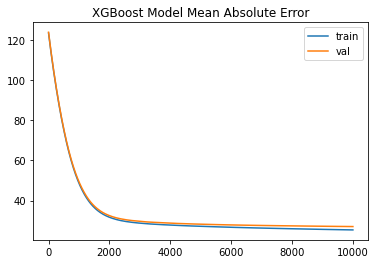

In [53]:
plt.title('XGBoost Model Mean Absolute Error')
plt.plot(xgboost_result['validation_0']['mae'], label='train')
plt.plot(xgboost_result['validation_1']['mae'], label='val')
plt.legend()

In [54]:
model_filename = input('')
xgboost_model.save_model(f'../models/xgboost/{model_filename}.json')

## Neural Network

### Normalize Data

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

col_to_norm = ['CO2/N2_selectivity', 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']
X_train_to_norm = X_train[col_to_norm]

samples_scaler = MinMaxScaler()
labels_scaler = MinMaxScaler()

In [60]:
features_norm = samples_scaler.fit_transform(X_train_to_norm)

y_train_norm = labels_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [61]:
X_train['CO2/N2_selectivity'] = features_norm[:, 0]
X_train['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'] = features_norm[:, 1]

In [62]:
X_test_to_norm = X_test[col_to_norm]
features_norm_test = samples_scaler.transform(X_test_to_norm)
y_test_norm = labels_scaler.transform(y_test.values.reshape(-1, 1))

In [63]:
X_test['CO2/N2_selectivity'] = features_norm_test[:, 0]
X_test['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'] = features_norm_test[:, 1]

### Create Model

In [64]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as layers

2021-10-02 22:31:42.882648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-02 22:31:42.882663: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [65]:
model = tfk.Sequential([
    layers.Input((8, )),
    layers.Dense(64),
    layers.Dense(64),
    layers.Dense(1, activation='sigmoid')
])

2021-10-02 22:31:43.855192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-02 22:31:43.855653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-02 22:31:43.855721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-02 22:31:43.855767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-02 22:31:43.855809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [66]:
model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = tfk.optimizers.SGD(learning_rate=1-5),
    metrics = [tfk.metrics.mean_squared_logarithmic_error]
)

In [67]:
X_train.head()

,CO2/N2_selectivity,heat_adsorption_CO2_P0.15bar_T298K [kcal/mol],topology_acs,topology_bcu,topology_etb,topology_fof,topology_nbo,topology_pcu,topology_pts,topology_rht,...,organic_linker2_57,organic_linker2_58,organic_linker2_59,metal_linker_1,metal_linker_2,metal_linker_3,metal_linker_4,metal_linker_9,metal_linker_10,metal_linker_12
29159,0.024620,0.273152,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11143,0.019556,0.254099,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
12682,0.037514,0.332842,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
34609,0.028771,0.301944,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2666,0.026836,0.276022,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [68]:
y_train_norm.max()

0.9999999999999999

In [69]:
history = model.fit(
    X_train, y_train_norm, validation_data=(X_test, y_test_norm),
    epochs=100, batch_size=128
)

2021-10-02 22:31:44.006840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


ValueError: in user code:

    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/namirinz/miniconda3/envs/tmlcc/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape (None, 174)


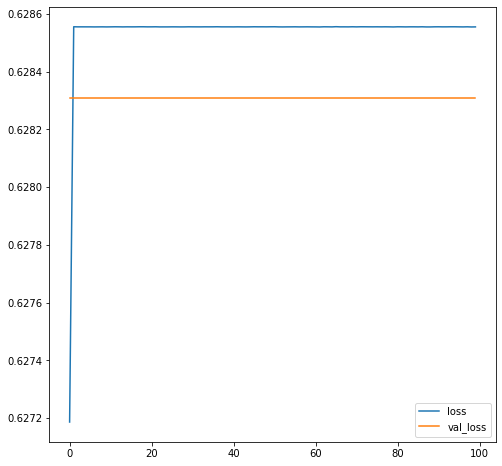

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()